In [1]:
%matplotlib inline
from cross_validation import *
from plots import *
%load_ext autoreload
%autoreload 2

In [2]:
y, data, ids = load_csv_data("train.csv")

# DATA VISUALISATION

In [3]:
# shape of the data
print(y.shape)
print(data.shape)

(250000,)
(250000, 30)


In [4]:
# signal to background ratio
n_background = y.tolist().count(-1)
n_signal = y.tolist().count(1)
print(100*n_signal/y.shape[0])

34.2668


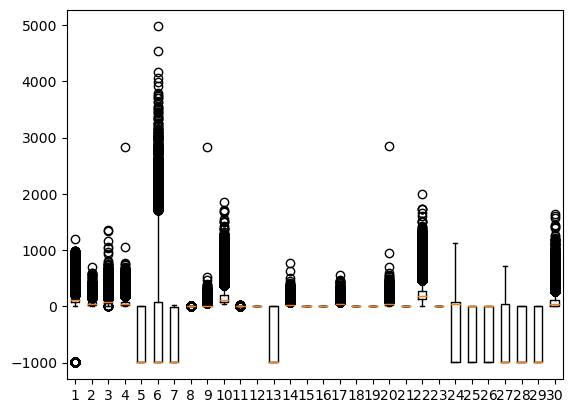

In [5]:
# boxplot of each feature
plt.boxplot(data)
plt.savefig(r'plots/initial_boxplots.png')
plt.show()

In [6]:
# see which features have a really low variance
std = np.std(data, axis=0)
indices_low_var = find_low_variance(std, 0.1)
print(indices_low_var[0])
# the array is empty -> none have low variance

[]


## Before pre-processing

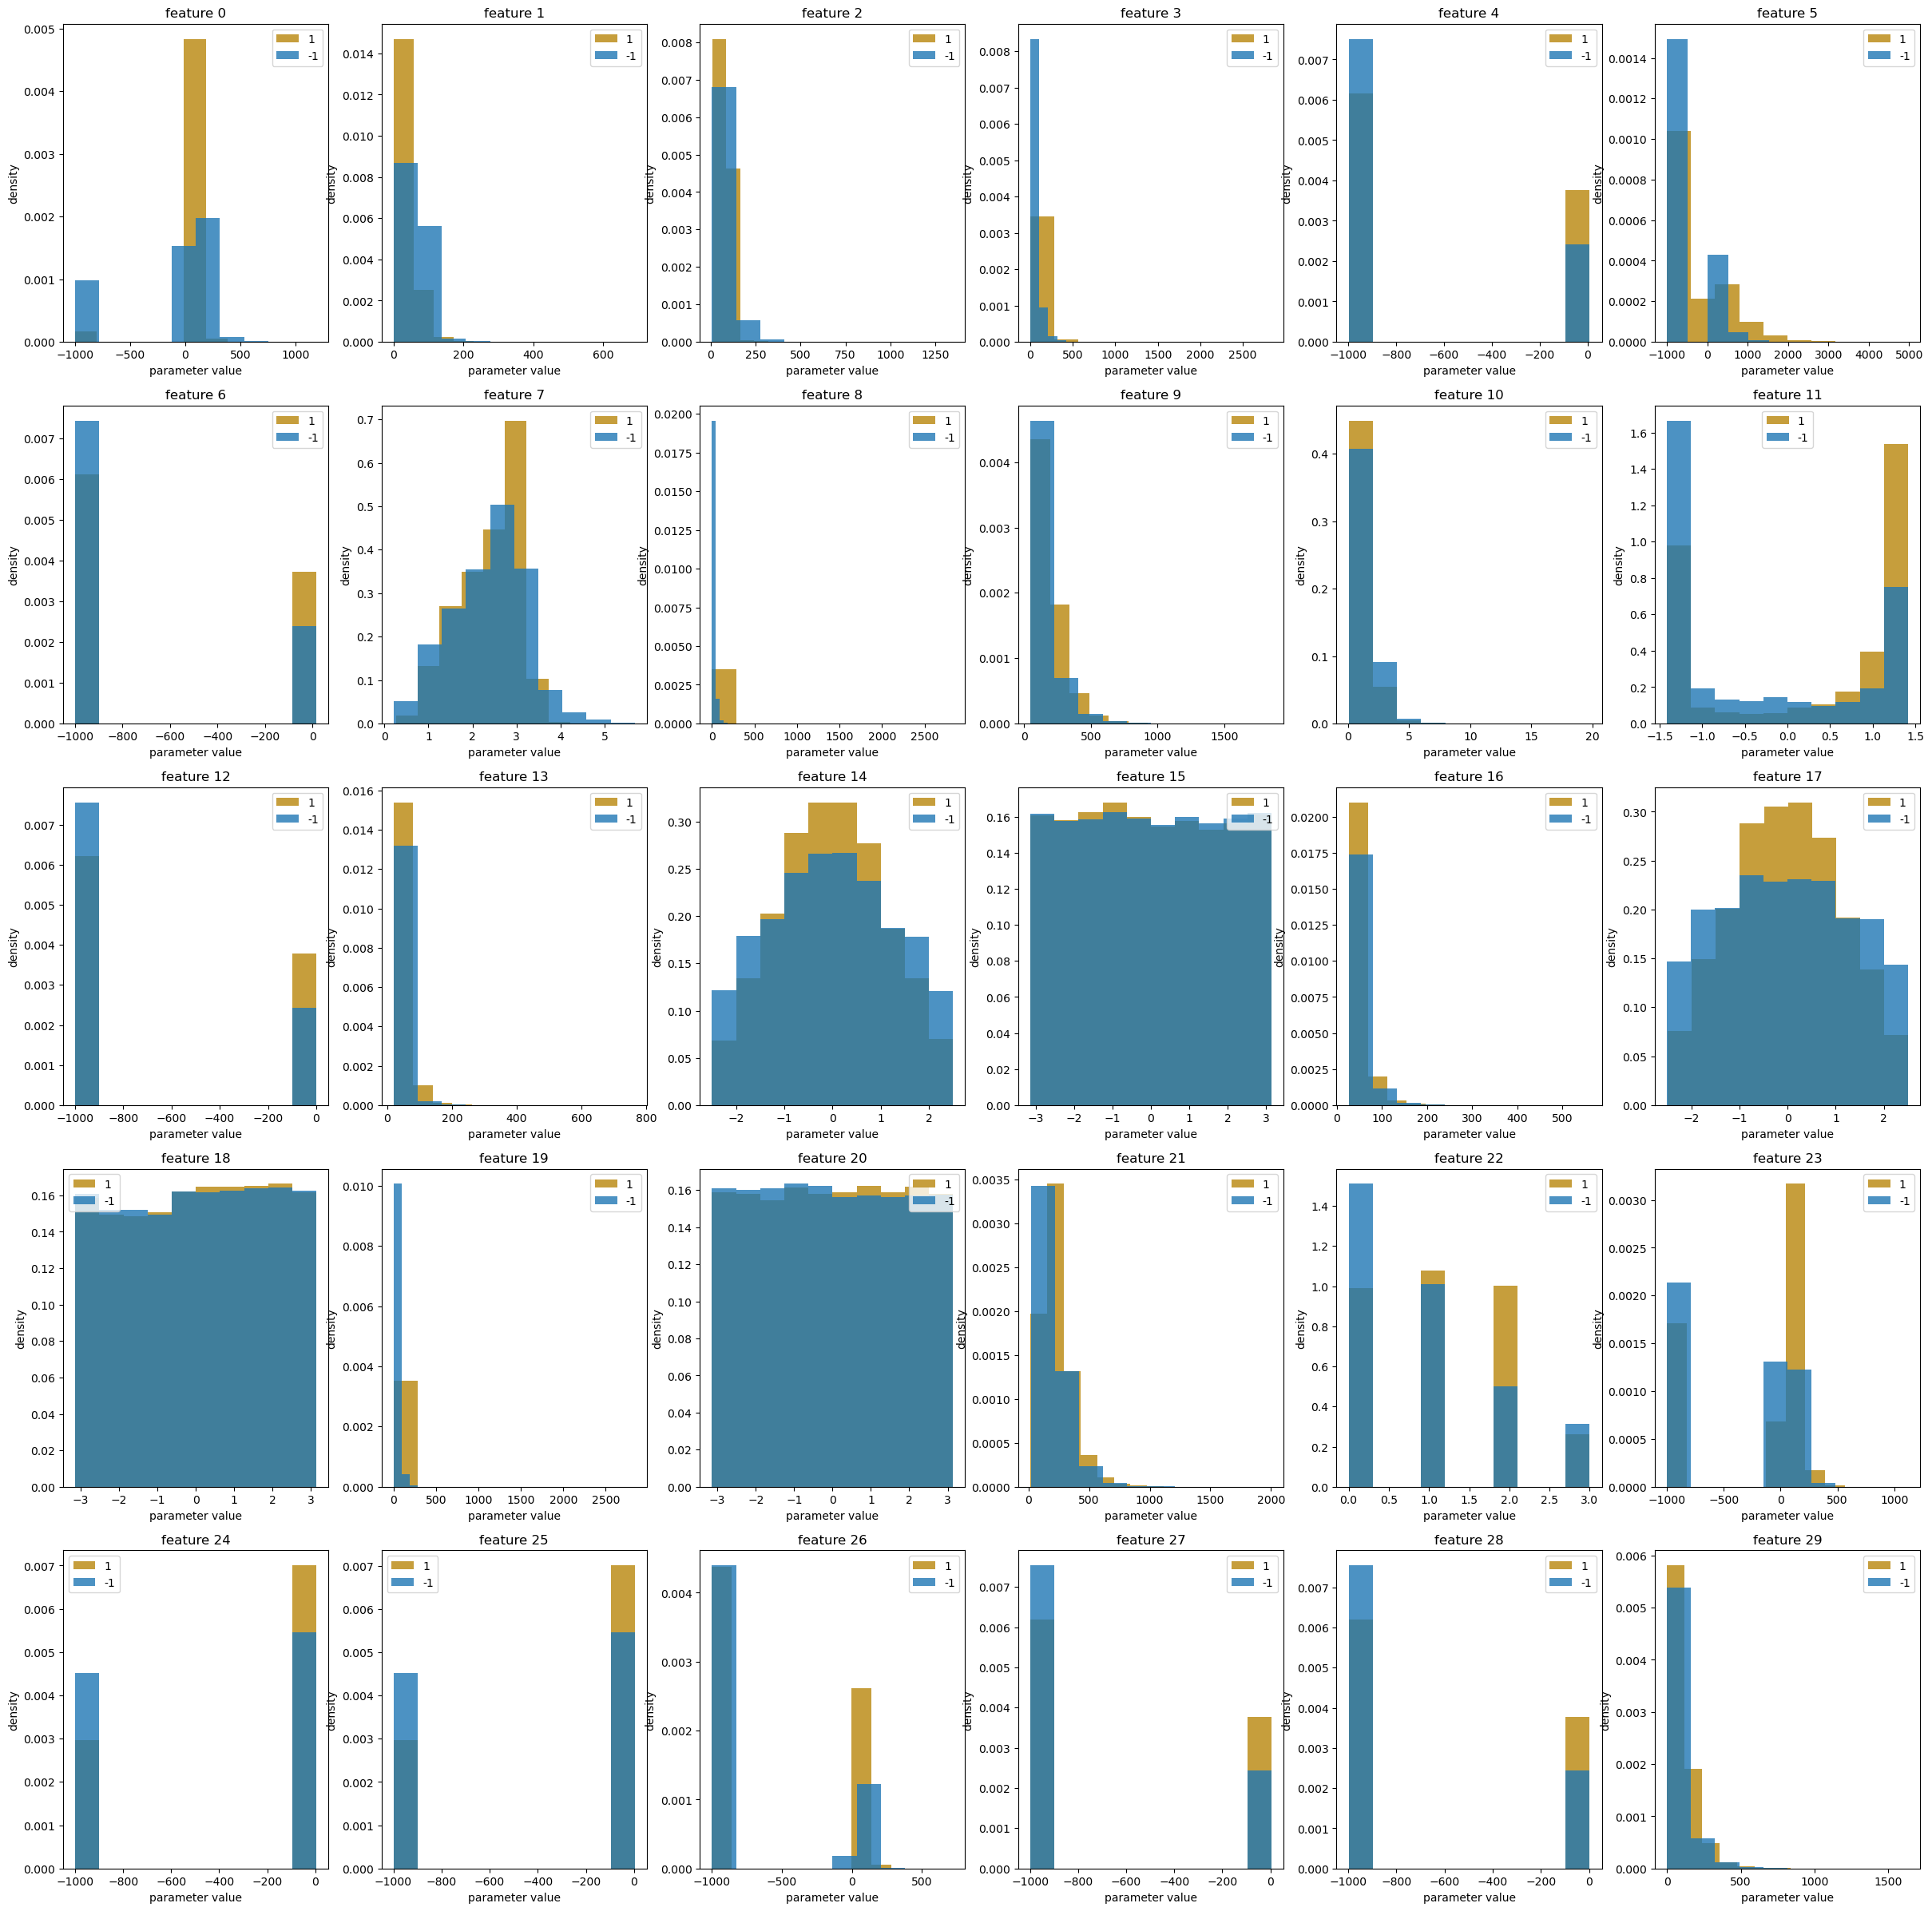

In [7]:
# plot distribution of 1 and -1 for each feature
fig, axs = plt.subplots(5, 6, figsize=(30,30))
data_signal = data[np.where(y==1)[0],:]
data_background = data[np.where(y==-1)[0],:]
n = 0
for i in range(5) :
    for j in range(6) :
        axs[i,j].hist(data_signal[:,n], alpha = 0.8, label="1", stacked=True, color = "darkgoldenrod", density = True)
        axs[i,j].hist(data_background[:,n], alpha = 0.8, label="-1", stacked=True, density = True)
        axs[i,j].legend()
        axs[i,j].set_ylabel("density")
        axs[i,j].set_xlabel("parameter value")
        axs[i,j].set_title("feature " + str(n))
        n = n + 1
plt.savefig(r'plots/initial_distributions.png')
plt.show()

## After pre-processing

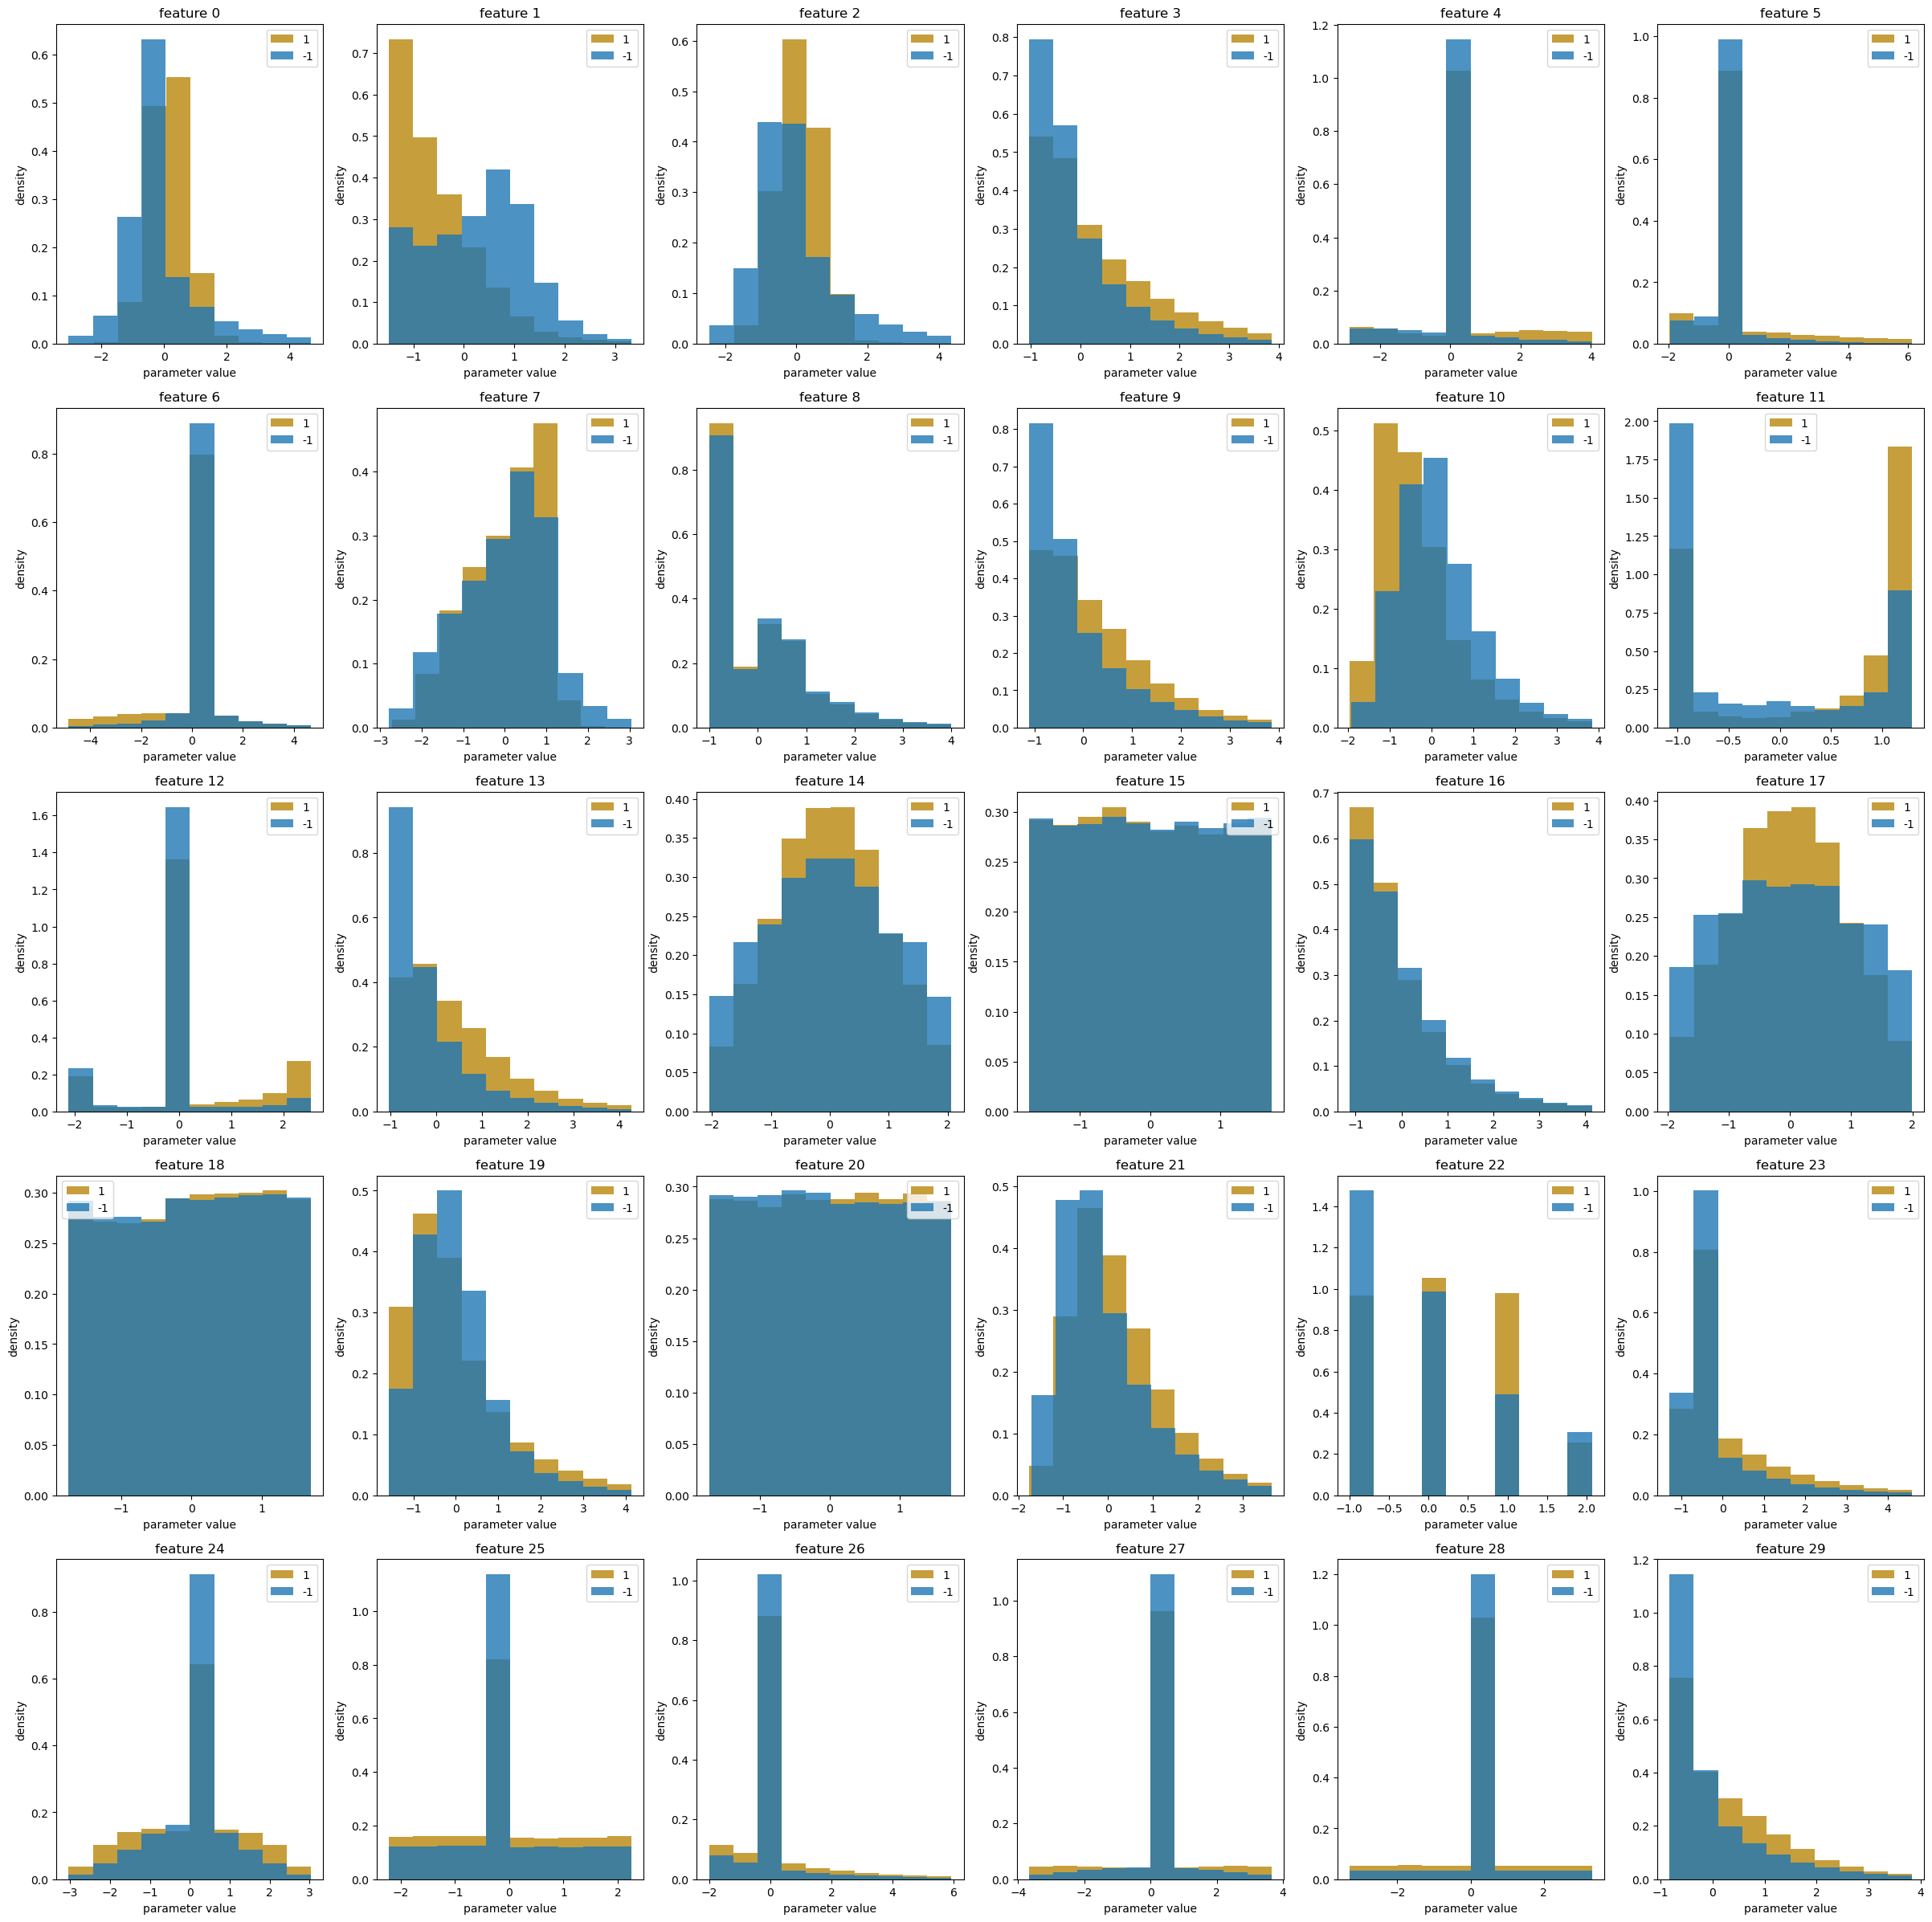

In [8]:
# distributions of the features after removing -999.0 and outliers and standardization
fig, axs = plt.subplots(5, 6, figsize=(30,30))
# remove -999 values and outliers
boolean_matrix = data == -999
data[boolean_matrix] = np.NaN
data = np.nan_to_num(data, nan=np.nanmedian(data, axis=0))
data = remove_outliers(data)
# standardize the data
data = standardize(data)

data_signal = data[np.where(y==1)[0],:]
data_background = data[np.where(y==-1)[0],:]

n = 0
for i in range(5) :
    for j in range(6) :
        axs[i,j].hist(data_signal[:,n], alpha = 0.8, label="1", stacked=True, color = "darkgoldenrod", density = True)
        axs[i,j].hist(data_background[:,n], alpha = 0.8, label="-1", stacked=True, density = True)
        axs[i,j].legend()
        axs[i,j].set_ylabel("density")
        axs[i,j].set_xlabel("parameter value")
        axs[i,j].set_title("feature " + str(n))
        n = n + 1
plt.savefig(r'plots/preprocessed_distributions.png')
plt.show()

# MODEL SELECTION

In [9]:
# set some global variables to have reproducible results
seed = 1
k_fold = 10
gammas = np.logspace(start=-10,stop=0,num=11)
degrees = range(1, 11)
lambdas = np.logspace(-10, 0, 11)

In [10]:
# load data set
y, data, labels = load_csv_data("train.csv")
x = data_preprocessing(data)

## Least Square

In [11]:
mse_tr, mse_te = cv_least_squares(y, x, k_fold, seed)
print(mse_te)
# mse = 0.3397819256478035

0.3397819256478035


## Gradient Descent

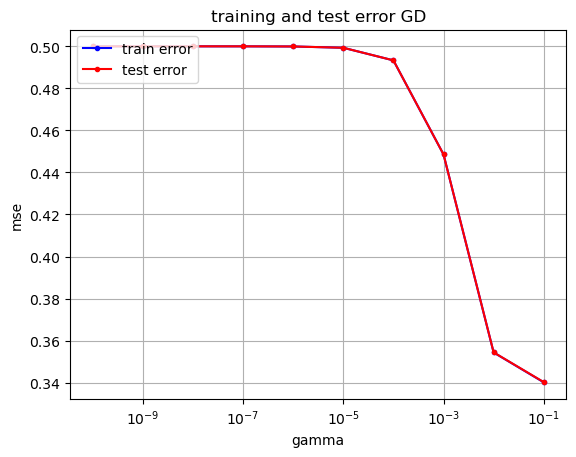

[0.1]
0.3402695945144494


In [18]:
gamma_mse_tr, gamma_mse_te = cv_gradient_des(y,x,gammas,k_fold, seed)
min_error_train = min(gamma_mse_tr)
min_error_test = min(gamma_mse_te)
mses_visualization(gamma_mse_tr[:10], gamma_mse_te[:10], gammas[:10], 'gamma', x_log_scale=True, title="training and test error GD")
min_gamma_test = gammas[np.where(gamma_mse_te == min_error_test)]

print(min_gamma_test)
# best gamma = 0.1
print(min_error_test)
# best mse = 0.3400572378456385

## Stochastic Gradient Descent

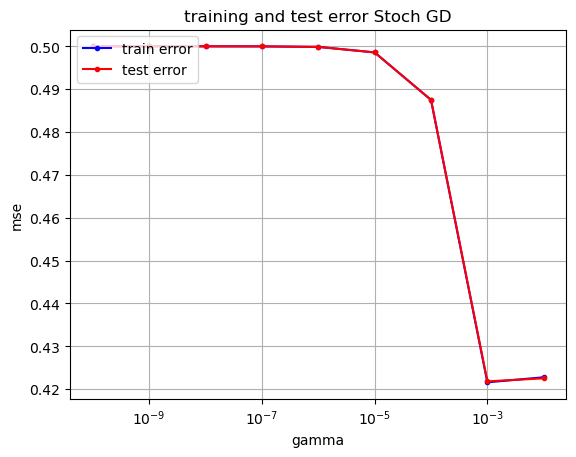

[0.001]
0.4217965349513464


In [19]:
# WARNING takes a long time to run
gamma_mse_tr, gamma_mse_te = cv_stoch_gradient_des(y, x, gammas, k_fold, seed)
mses_visualization(gamma_mse_tr[:9], gamma_mse_te[:9], gammas[:9], 'gamma', x_log_scale=True, title="training and test error Stoch GD")
min_error_test = min(gamma_mse_te)
min_gamma_test = gammas[np.where(gamma_mse_te == min_error_test)]
print(min_gamma_test)
# best gamma = 0.001
print(min_error_test)
# best mse = 0.4218853488492586

## Polynomial features expansion (1st method)

In [21]:
# WARNING: takes a long time to run
# find the optimal degree to which each feature should be expanded
best_degrees, degree_mse = find_best_degree(y, x)
print(best_degrees)
# best_degrees = [10, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 1, 5, 4, 1, 10, 1, 9, 4, 10, 5, 5, 10, 1, 4, 1, 1, 4, 1, 1]

[10  8 10 10 10 10 10 10 10 10 10 10 10  9 10  1  5  4  1 10  1  9  4 10
  5  5 10  1  4  1  1  4  1  1]


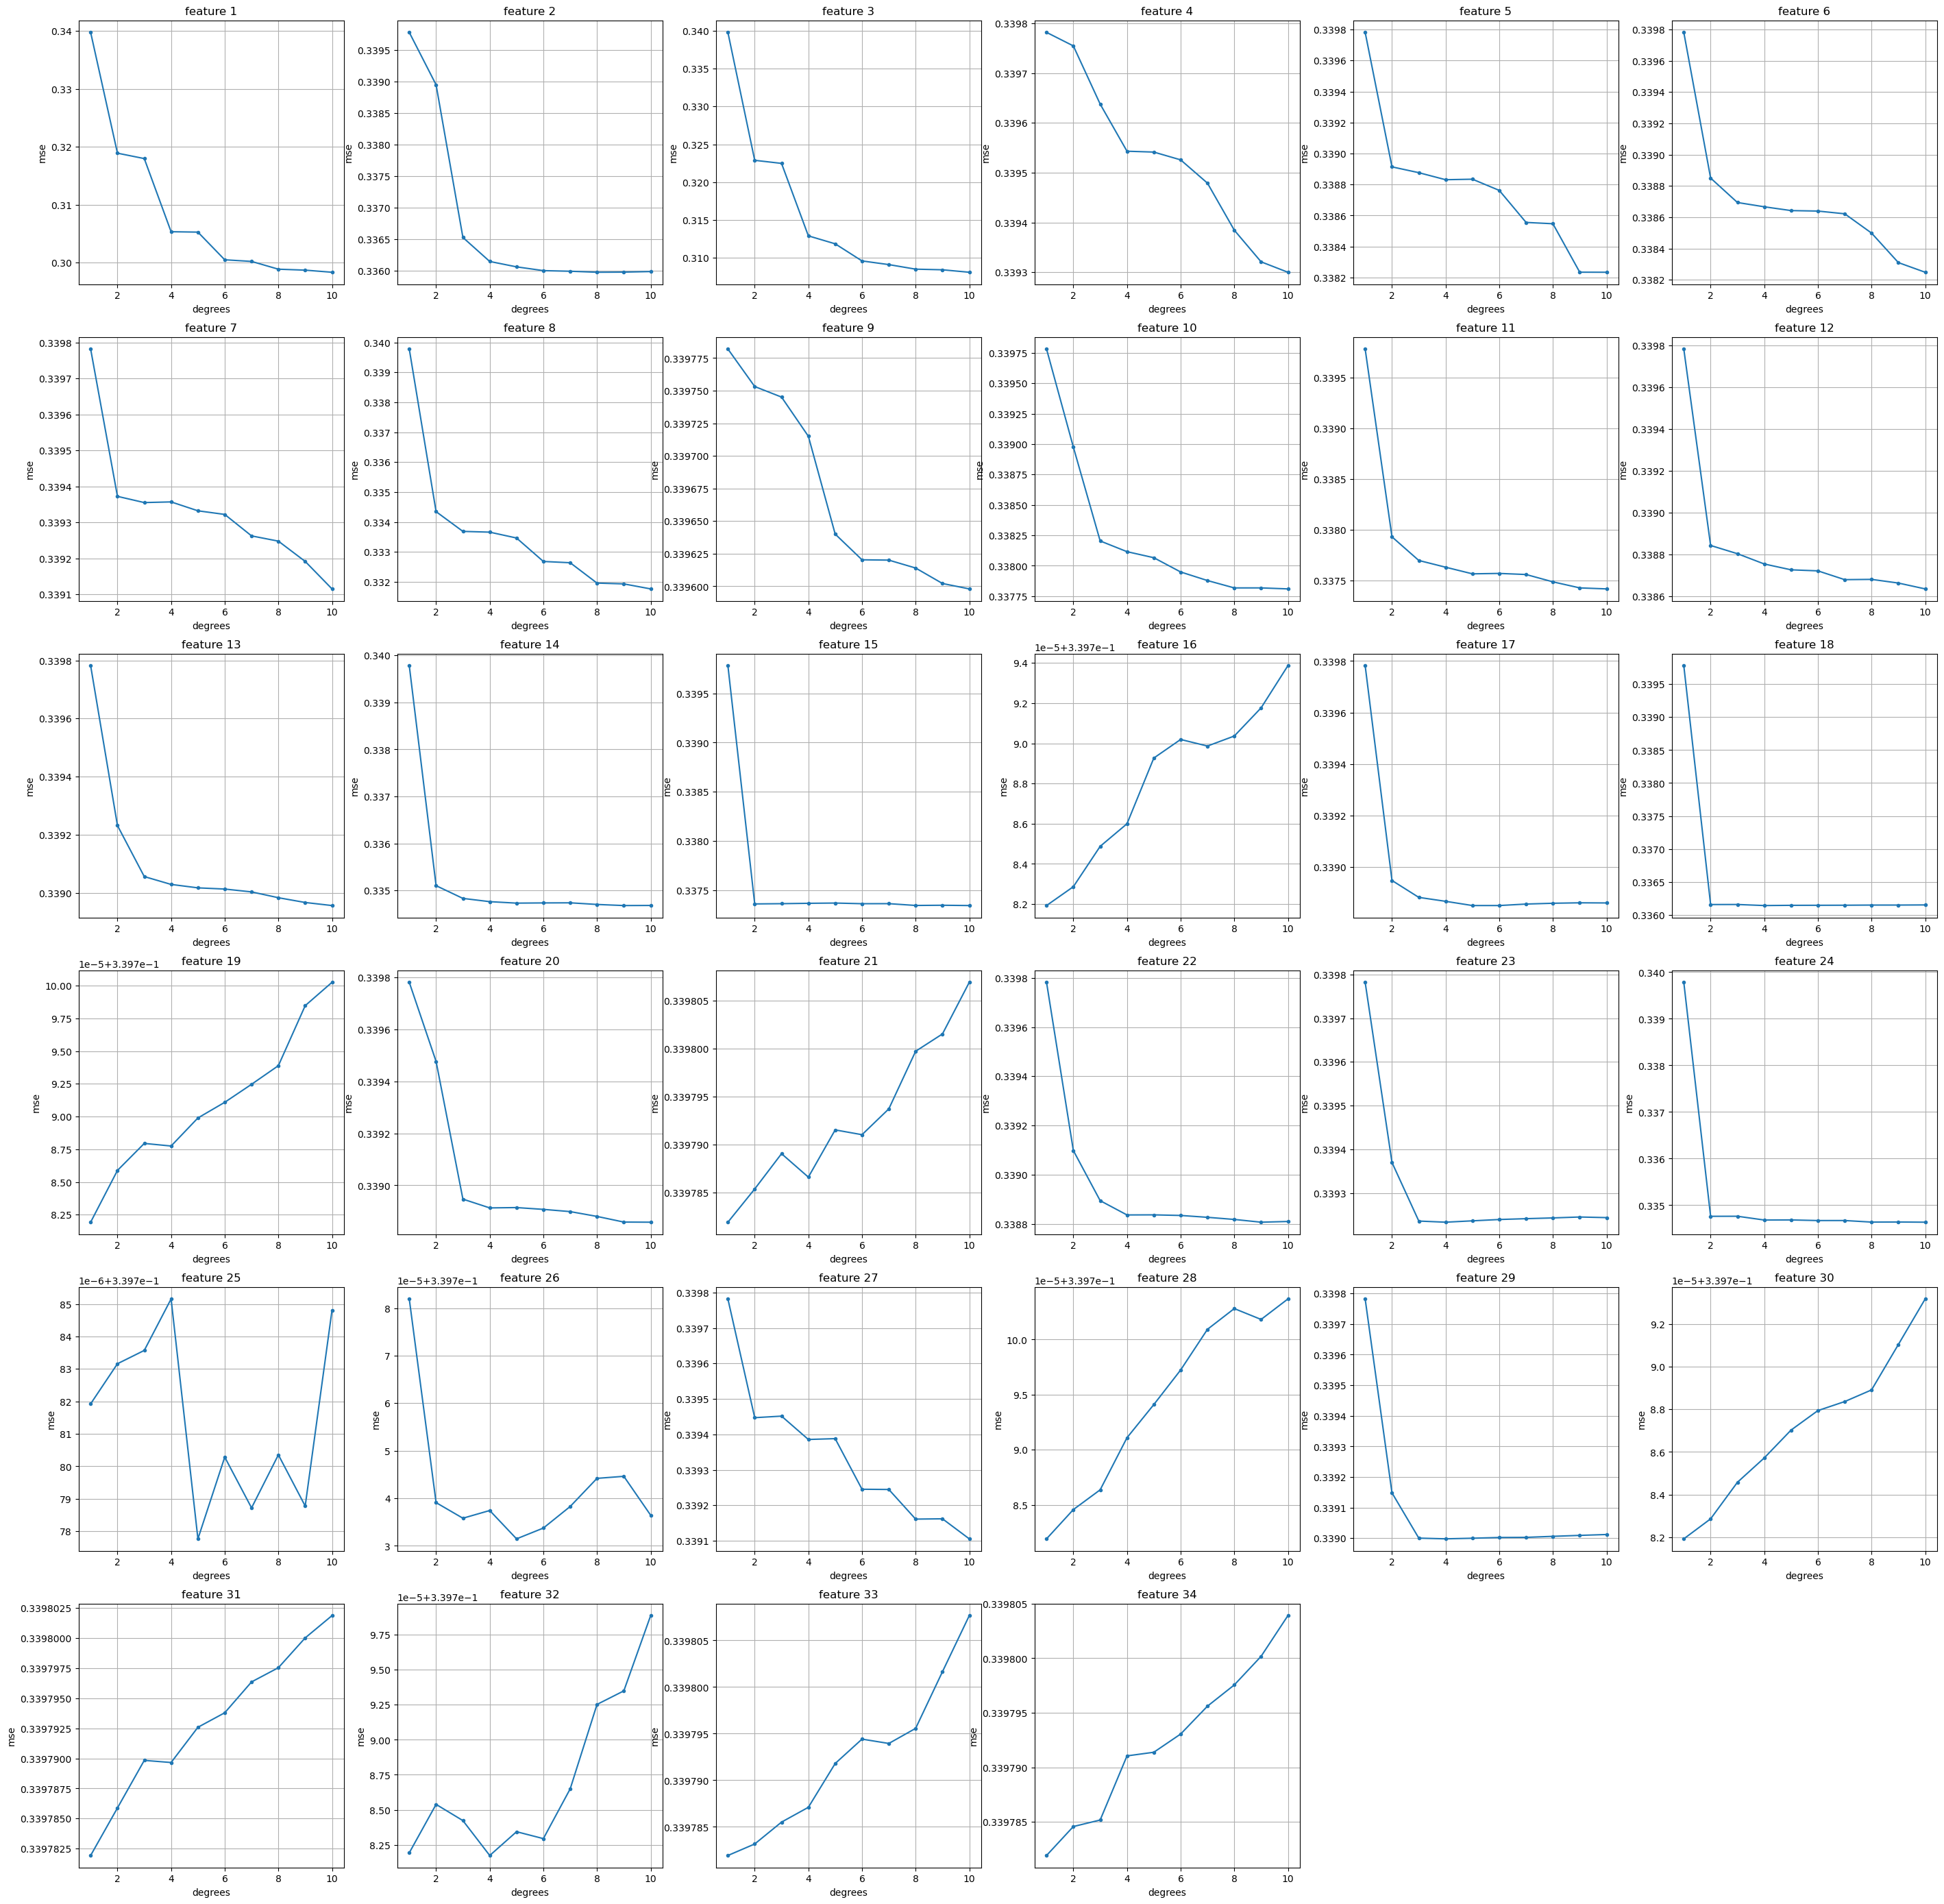

In [22]:
features_degrees_visualization(degree_mse, degrees)

In [23]:
# cross validation to get the test error with this polynomial expansion
# redefine x so that it is not in polynomial expansion anymore
x = data_preprocessing(data)
x = features_poly_extension(x, best_degrees)
mse_tr, mse_te = cv_least_squares(y, x, k_fold, seed)
print(mse_te)
# mse = 0.2724963991748842

0.2724963991748842


### Ridge regularization

1e-08
0.2724963711163649


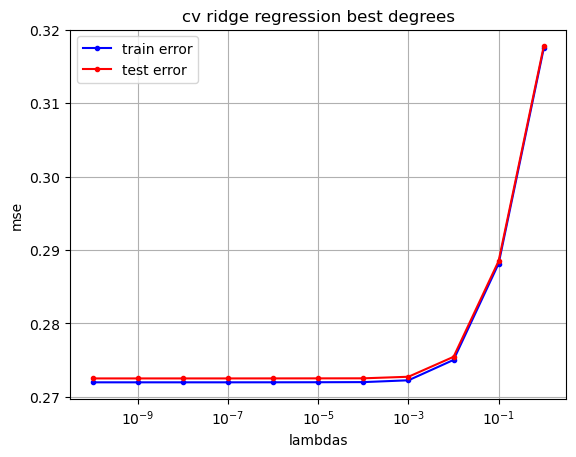

In [24]:
# redefine x so that it is not in polynomial expansion anymore
x = data_preprocessing(data)
best_degrees = [10, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 1, 5, 4, 1, 10, 1, 9, 4, 10, 5, 5, 10, 1, 4, 1, 1, 4, 1, 1]
mse_tr, mse_te = cv_best_degrees_ridge(y, x, best_degrees, lambdas, k_fold, seed)
min_mse_te = np.min(mse_te)
min_lambda_te = lambdas[np.argmin(mse_te)]
# best lambda = 1e-08
print(min_lambda_te)
# best mse = 0.2724963711163649
print(min_mse_te)
mses_visualization(mse_tr, mse_te, lambdas, "lambdas", title="cv ridge regression best degrees", x_log_scale=True)

## Polynomial features expansion (2nd method) + Ridge regularization

In [61]:
# redefine x so that it is not in polynomial expansion anymore
x = data_preprocessing(data)
mse_te, best_degree, best_lambda = cv_poly_ridge(y, x, degrees=degrees, k_fold=k_fold, lambdas=lambdas)

print(mse_te)
# best mse = 0.2726021387641882
print(best_degree)
# best degree = 10
print(best_lambda)
# best lambda = 0.0001

0.2726021387641882
10
0.0001


In [ ]:
# try the same method but with removing features 15, 18, 20 and outliers at +/- 3*std
# redefine x so that it is not in polynomial expansion anymore
x = data_preprocessing_improved(data, col_to_remove=[15, 18, 20])
mse_te, best_degree, best_lambda = cv_poly_ridge(y, x, degrees=degrees, k_fold=k_fold, lambdas=lambdas)
print(mse_te)
# best mse = 0.26478668747222267
print(best_degree)
# best degree = 10
print(best_lambda)
# best lambda = 1e-07

## Logistic Regression

Current iteration=<built-in function iter>, loss=0.6931471805599245
Current iteration=<built-in function iter>, loss=0.6931437161439741
Current iteration=<built-in function iter>, loss=0.6931402518447375
Current iteration=<built-in function iter>, loss=0.6931367876622303
Current iteration=<built-in function iter>, loss=0.693133323596447
Current iteration=<built-in function iter>, loss=0.6931298596473822
Current iteration=<built-in function iter>, loss=0.6931263958150309
Current iteration=<built-in function iter>, loss=0.6931229320993876
Current iteration=<built-in function iter>, loss=0.6931194685004469
Current iteration=<built-in function iter>, loss=0.6931160050182034
Current iteration=<built-in function iter>, loss=0.6931125416526523
Current iteration=<built-in function iter>, loss=0.6931090784037879
Current iteration=<built-in function iter>, loss=0.6931056152716049
Current iteration=<built-in function iter>, loss=0.6931021522560977
Current iteration=<built-in function iter>, loss=

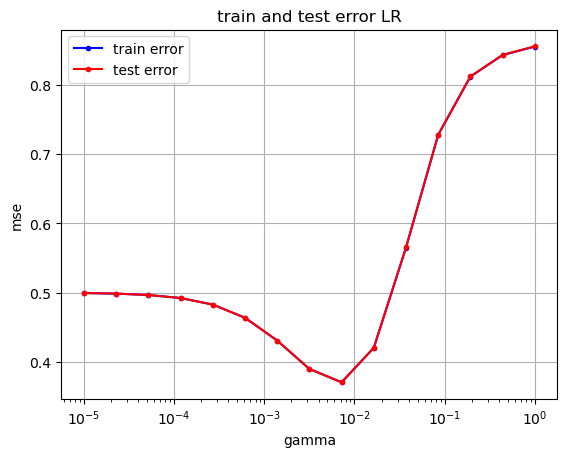

Min gamma train: [0.00719686]
Min error train: 0.37050609069092083
Min gamma test: [0.00719686]
Min error test: 0.37056619559274206


In [25]:
# re-process the data set so that it is not in polynomial expansion anymore
x = data_preprocessing(data)
initial_w = np.zeros(x.shape[1])
max_iters = 100
gammas = np.logspace(-5, 0, 15)

gamma_mse_train, gamma_mse_test = cv_logistic_regression(y, x, gammas, k_fold, seed)
mses_visualization(gamma_mse_train, gamma_mse_test, gammas, 'gamma', x_log_scale=True, title="train and test error LR")

min_error_train = min(gamma_mse_train)
min_error_test = min(gamma_mse_test)

min_gamma_train = gammas[np.where(gamma_mse_train == min_error_train)]
min_gamma_test = gammas[np.where(gamma_mse_test == min_error_test)]

print("Min gamma train:", min_gamma_train)
# Min gamma train: [0.01389495]
print("Min error train:", min_error_train)
# Min error train: 0.5681829093377588

print("Min gamma test:", min_gamma_test)
# Min gamma test: [0.00372759]
print("Min error test:", min_error_test)
# Min error test: 0.39531978100633747

## Logistic Regression with Polynomial Expansion and Ridge Regularization

In [ ]:
x = data_preprocessing(data)
initial_w = np.zeros(x.shape[1])
max_iters = 200
lambdas = np.logspace(-5, 0, 15)
degrees = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

best_mse, best_degrees, best_lambdas = cv_poly_ridge_logistic(y, x, degrees, k_fold, lambdas, seed)
print ("Best MSE:", best_mse)
# Best MSE: 0.38246238225599327
print ("Best Degrees:", best_degrees)
# Best Degrees: 2
print ("Best Lambdas:", best_lambdas)
# Best Lambdas: 0.19306977288832497